# Google drive mount
#### * google colab 사용 시, google drive 내 데이터를 사용하기 위한 절차

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 작업 경로 설정
#### * csv가 존재하는 작업 경로 설정

In [2]:
import os
os.chdir('/content/drive/MyDrive/숨고/양희성님(요통발생예측)')

# 현재 분석 코딩을 위한 필요 library import


In [ ]:
# 아래 코드 실행 후, 런타임 다시시작 필요 이후 현재 코드는 건너뛰시면 됩니다.
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
!pip install catboost

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font', family='NanumBarunGothic')

# Data load
#### * pandas를 이용해 csv파일 load
- 데이터를 보면 범주형과 수치형 변수들이 섞여 있음을 확인 가능
- 결측치 다수 존재

In [6]:
data = pd.read_csv("./data.csv")

In [ ]:
data

,요통,체중조절,음주경험,수면시간,흡연여부,근력운동,유연성운동,아침,점심,저녁,외식,식이요법,앉는시간
0,1,4,2,5,2,1,1,1,1,1,7,2,18
1,1,3,2,6,2,1,1,1,1,1,6,2,18
2,1,1,2,6,3,5,6,4,1,1,5,2,18
3,2,4,2,6,2,1,3,1,1,1,3,2,18
4,1,1,2,3,3,1,6,1,1,1,7,1,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860,2,1,2,7,3,1,4,1,1,1,5,2,1
1861,2,3,1,6,3,1,6,,,,,,1
1862,1,2,2,6,2,1,1,1,3,1,7,2,1
1863,1,1,2,8,2,5,6,1,1,1,5,1,1


In [11]:
# 아침 변수에 대한 결측값 확인 코드
display(data.loc[data['아침']==" "])

# 아침 변수에 대한 결측값 수 확인 코드
print("결측값 수:", len(data.loc[data['아침']==" "]))

,요통,체중조절,음주경험,수면시간,흡연여부,근력운동,유연성운동,아침,점심,저녁,외식,식이요법,앉는시간
8,1,4,2,6,3,1,1,,,,,,17
10,2,2,2,5,3,6,6,,,,,,17
47,2,2,2,7,2,4,6,,,,,,15
48,2,1,1,7,3,1,4,,,,,,15
49,2,4,2,6,3,1,6,,,,,,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1824,1,4,2,6,3,1,1,,,,,,2
1826,1,2,2,6,2,3,3,,,,,,2
1856,1,3,2,8,2,1,2,,,,,,1
1857,2,2,2,5,1,1,6,,,,,,1


결측값 수: 177


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1865 entries, 0 to 1864
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   요통      1865 non-null   int64 
 1   체중조절    1865 non-null   int64 
 2   음주경험    1865 non-null   int64 
 3   수면시간    1865 non-null   int64 
 4   흡연여부    1865 non-null   int64 
 5   근력운동    1865 non-null   int64 
 6   유연성운동   1865 non-null   int64 
 7   아침      1865 non-null   object
 8   점심      1865 non-null   object
 9   저녁      1865 non-null   object
 10  외식      1865 non-null   object
 11  식이요법    1865 non-null   object
 12  앉는시간    1865 non-null   int64 
dtypes: int64(8), object(5)
memory usage: 189.5+ KB


# 각 변수별 처리 진행
- 순서형에 맞게 크기순으로 값 재배열(ex, 4:노력안함 -> 0:노력안함)
- 결측값 처리

In [ ]:
#요통 변수 처리
data[['요통']] = data[['요통']].replace({2:0})

In [ ]:
#체중조절 변수 처리
data[['체중조절']] = data[['체중조절']].replace({4:0})

In [ ]:
#음주경험 변수 처리
data[['음주경험']] = data[['음주경험']].replace({1:0, 2:1})

In [ ]:
#흡연여부 변수 처리
data[['흡연여부']] = data[['흡연여부']].replace({3:0})

In [ ]:
#근력운동 변수 처리
data[['근력운동']] = data[['근력운동']].replace({1:0,2:1,3:2,4:3,5:4,6:5})

In [ ]:
#유연성운동 변수 처리
data[['유연성운동']] = data[['유연성운동']].replace({1:0,2:1,3:2,4:3,5:4,6:5})

In [ ]:
#아침, 점심, 저녁 변수 처리
# - 요통 범주별 최빈값으로 대체
def replace_value(col):
    data[[col]] = data[[col]].replace({" ":np.nan})
    for i in range(len(data)):
        if pd.isna(data.loc[i, col]):
            mode_value = data.loc[data['요통']==data.loc[i, '요통'], col].mode()[0]
            data.loc[i, col] = mode_value
    data[[col]] = data[[col]].astype(int)
    data[[col]] = data[[col]].replace({1:3,2:2,3:1,4:0})
    return data[[col]]

data[['아침']] = replace_value('아침')
data[['점심']] = replace_value('점심')
data[['저녁']] = replace_value('저녁')

In [ ]:
#외식 변수 처리
data[["외식"]] = data[["외식"]].replace({" ":np.nan})
for i in range(len(data)):
    if pd.isna(data.loc[i, "외식"]):
        mode_value = data.loc[data['요통']==data.loc[i, '요통'], "외식"].mode()[0]
        data.loc[i, "외식"] = mode_value
data[["외식"]] = data[["외식"]].astype(int)
data[["외식"]] = data[["외식"]].replace({1:6,2:5,3:4,4:3,5:2,6:1,7:0})

In [ ]:
#식이요법 변수 처리
data[["식이요법"]] = data[["식이요법"]].replace({" ":np.nan})
for i in range(len(data)):
    if pd.isna(data.loc[i, "식이요법"]):
        mode_value = data.loc[data['요통']==data.loc[i, '요통'], "식이요법"].mode()[0]
        data.loc[i, "식이요법"] = mode_value
data[["식이요법"]] = data[["식이요법"]].astype(int)
data[["식이요법"]] = data[["식이요법"]].replace({1:0,2:1})

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1865 entries, 0 to 1864
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   요통      1865 non-null   int64
 1   체중조절    1865 non-null   int64
 2   음주경험    1865 non-null   int64
 3   수면시간    1865 non-null   int64
 4   흡연여부    1865 non-null   int64
 5   근력운동    1865 non-null   int64
 6   유연성운동   1865 non-null   int64
 7   아침      1865 non-null   int64
 8   점심      1865 non-null   int64
 9   저녁      1865 non-null   int64
 10  외식      1865 non-null   int64
 11  식이요법    1865 non-null   int64
 12  앉는시간    1865 non-null   int64
dtypes: int64(13)
memory usage: 189.5 KB


# 학습을 위한 데이터 처리
 - 데이터 불균형으로, 요통발생 기준 7:3 비율로 샘플링
 - train:test = 7:3 비율로 분리
 - 0 또는 1의 값만 가지는 변수는 놔두고 나머지 순서형 연속형 변수의 경우 minmax normalization 진행

In [ ]:
# 데이터 불균형 문제
data['요통'].value_counts()

0    1552
1     313
Name: 요통, dtype: int64

In [ ]:
# sampling
data_0 = data.loc[data['요통']==0].sample(n=round((7*len(data.loc[data['요통']==1]))/3), random_state=2023).reset_index(drop=True)
data_1 = data.loc[data['요통']==1].reset_index(drop=True)
data_sampled = pd.concat([data_0, data_1], axis=0).reset_index(drop=True)
data_sampled

,요통,체중조절,음주경험,수면시간,흡연여부,근력운동,유연성운동,아침,점심,저녁,외식,식이요법,앉는시간
0,0,2,0,8,0,0,0,3,3,3,4,1,8
1,0,1,0,4,2,0,0,3,3,3,1,1,8
2,0,1,0,8,2,5,4,3,3,3,1,1,1
3,0,0,1,4,0,0,0,3,3,3,2,1,6
4,0,0,0,8,0,0,0,3,3,0,6,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1038,1,0,1,6,0,0,0,3,3,3,0,1,1
1039,1,0,0,7,2,0,0,3,3,3,2,1,1
1040,1,3,0,8,2,0,1,3,3,3,1,1,1
1041,1,2,0,6,2,0,0,3,1,3,0,1,1


In [ ]:
# split
x_train, x_test, y_train, y_test = train_test_split(data_sampled.drop(['요통'],axis=1), data_sampled[['요통']], test_size=0.3, stratify=data_sampled['요통'], random_state=2023)

In [ ]:
y_train = y_train.values.reshape(-1)
y_test = y_test.values.reshape(-1)

In [ ]:

# scaling
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train.drop(['음주경험', '식이요법'], axis=1))
x_test_scaled = scaler.transform(x_test.drop(['음주경험', '식이요법'], axis=1))

x_train.loc[:,[i for i in x_train.columns if i not in ['요통', '음주경험', '식이요법']]] = x_train_scaled
x_test.loc[:,[i for i in x_test.columns if i not in ['요통', '음주경험', '식이요법']]] = x_test_scaled


# 분류 모델 최적화
 - 대상 모델 : logistic regression, KNN, Naive baysian, Decision tree, Randomforest, xgboost, lgb, catboost
 - 각 모델의 하이퍼 파라미터는 최적화 작업을 통해 결정
 - 최적화 작업은 grid search를 통해(5fold) 각 모델의 임의 하이퍼파라미터별로 테스트하여 최적의 모델 검출

In [ ]:
# logistic regression
logistic_model = LogisticRegression(n_jobs=-1, random_state=2023)
logistic_params = {'C': [0.1, 1, 10, 20]}
logistic_grid = GridSearchCV(logistic_model, logistic_params, cv=7, scoring='roc_auc',n_jobs=-1)
logistic_grid.fit(x_train, y_train)
logistic_best_model = logistic_grid.best_estimator_


# KNN
knn_model = KNeighborsClassifier(n_jobs=-1)
knn_params = {
    'n_neighbors': [3, 7, 20],
    'weights': ['uniform', 'distance']
}
knn_grid = GridSearchCV(knn_model, knn_params, cv=7, scoring='roc_auc',n_jobs=-1)
knn_grid.fit(x_train, y_train)
knn_best_model = knn_grid.best_estimator_

# NB
nb_model = GaussianNB()
nb_params = {}
nb_grid = GridSearchCV(nb_model, nb_params, cv=7, scoring='roc_auc',n_jobs=-1)
nb_grid.fit(x_train, y_train)
nb_best_model = nb_grid.best_estimator_

# decision tree
dt_model = DecisionTreeClassifier()
dt_params = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3]
}
dt_grid = GridSearchCV(dt_model, dt_params, cv=7, scoring='roc_auc',n_jobs=-1)
dt_grid.fit(x_train, y_train)
dt_best_model = dt_grid.best_estimator_

# RandomForest
rf_model = RandomForestClassifier(n_jobs=-1, random_state=2023)
rf_params = {
    'n_estimators': [50, 100, 500],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf_grid = GridSearchCV(rf_model, rf_params, cv=7, scoring='roc_auc',n_jobs=-1)
rf_grid.fit(x_train, y_train)
rf_best_model = rf_grid.best_estimator_

# xgboost
xgb_model = XGBClassifier(n_jobs=-1, random_state=2023)
xgb_params = {'n_estimators': [10, 50, 100], 'max_depth': [None, 5, 10], 'learning_rate':[0.1, 0.01]}
xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=7, scoring='roc_auc',n_jobs=-1)
xgb_grid.fit(x_train, y_train)
xgb_best_model = xgb_grid.best_estimator_

# lgb
lgb_model = LGBMClassifier(n_jobs=-1, random_state=2023)
lgb_params = {'n_estimators': [10, 50, 100], 'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'learning_rate':[0.1, 0.01]}
lgb_grid = GridSearchCV(lgb_model, lgb_params, cv=7, scoring='roc_auc',n_jobs=-1)
lgb_grid.fit(x_train, y_train)
lgb_best_model = lgb_grid.best_estimator_

# catboost
cat_model = CatBoostClassifier(random_state=2023)
cat_params = {'learning_rate':[0.1, 0.01], 'n_estimators': [10, 50, 100], 'max_depth': [5, 7, 10]}
cat_grid = GridSearchCV(cat_model, cat_params, cv=7, scoring='roc_auc',n_jobs=-1)
cat_grid.fit(x_train, y_train)
cat_best_model = cat_grid.best_estimator_

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=2. Current value: min_data_in_leaf=2
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=2. Current value: min_data_in_leaf=2
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 219, number of negative: 511
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 70


In [ ]:
# 모델별 최적의 하이퍼 파라미터 출력
for i in [logistic_grid, knn_grid, nb_grid, dt_grid, rf_grid, xgb_grid, lgb_grid, cat_grid]:
    print(f"{i}에 대한 최적 파라미터 : {i.best_params_}")

# 모델 테스트 진행

In [ ]:
# 모델 리스트
models = [
    ('Logistic Regression', logistic_best_model),
    ('KNN', knn_best_model),
    ('Naive Bayesian', nb_best_model),
    ('Decision Tree', dt_best_model),
    ('Random Forest', rf_best_model),
    ('xgboost', xgb_best_model),
    ('light gbm', lgb_best_model),
    ('catboost', cat_best_model)
]

# 지표 리스트
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUROC']

results = {metric: [] for metric in metrics}

# 모델 평가 및 결과 저장
for name, model in models:
    model.fit(x_train, y_train)
    y_pred_proba = model.predict_proba(x_test)[:, 1]
    y_pred = model.predict(x_test)
    results['Accuracy'].append(accuracy_score(y_test, y_pred))
    results['Precision'].append(precision_score(y_test, y_pred))
    results['Recall'].append(recall_score(y_test, y_pred))
    results['F1'].append(f1_score(y_test, y_pred))
    results['AUROC'].append(roc_auc_score(y_test, y_pred_proba))

# 결과 테이블 생성
results_df = pd.DataFrame(results, index=[name for name, _ in models]).sort_values(['AUROC'], ascending=False)

# 결과 출력
display(results_df)

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=2. Current value: min_data_in_leaf=2
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=2. Current value: min_data_in_leaf=2
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 219, number of negative: 511
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 70


,Accuracy,Precision,Recall,F1,AUROC
Random Forest,0.677316,0.418605,0.191489,0.262774,0.623943
Logistic Regression,0.699681,0.500000,0.053191,0.096154,0.616487
light gbm,0.702875,0.521739,0.127660,0.205128,0.606359
Naive Bayesian,0.693291,0.475000,0.202128,0.283582,0.600991
xgboost,0.709265,0.565217,0.138298,0.222222,0.594263
catboost,0.702875,0.600000,0.031915,0.060606,0.590256
Decision Tree,0.626198,0.358025,0.308511,0.331429,0.559944
KNN,0.664537,0.260870,0.063830,0.102564,0.535801


# 각 모델에 대해 변수 중요도 계산 및 시각화

현재 model : RandomForestClassifier


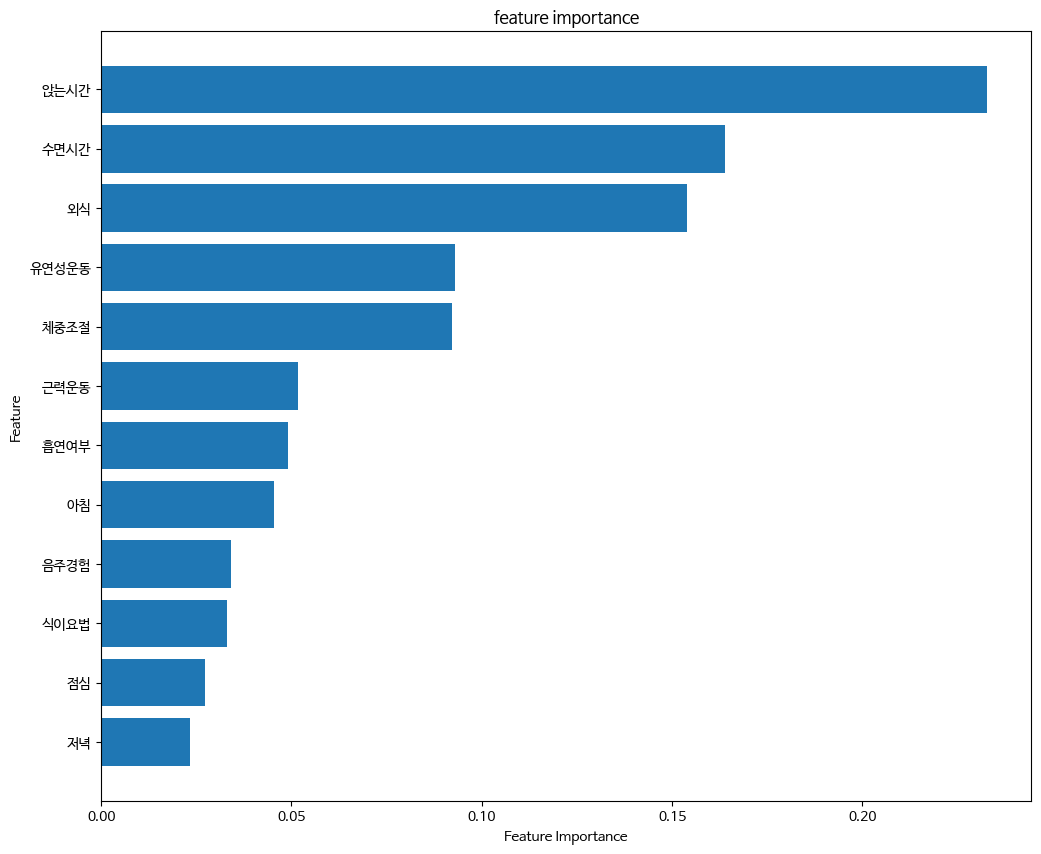

현재 model : LGBMClassifier


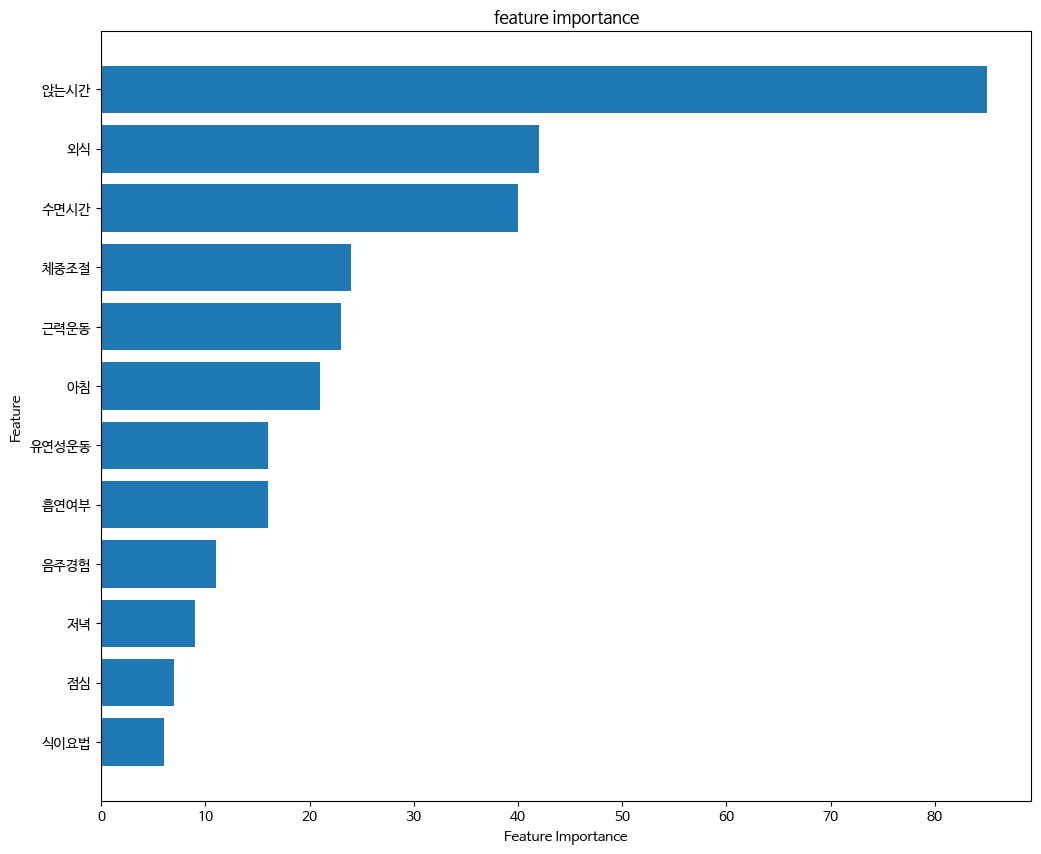

현재 model : XGBClassifier


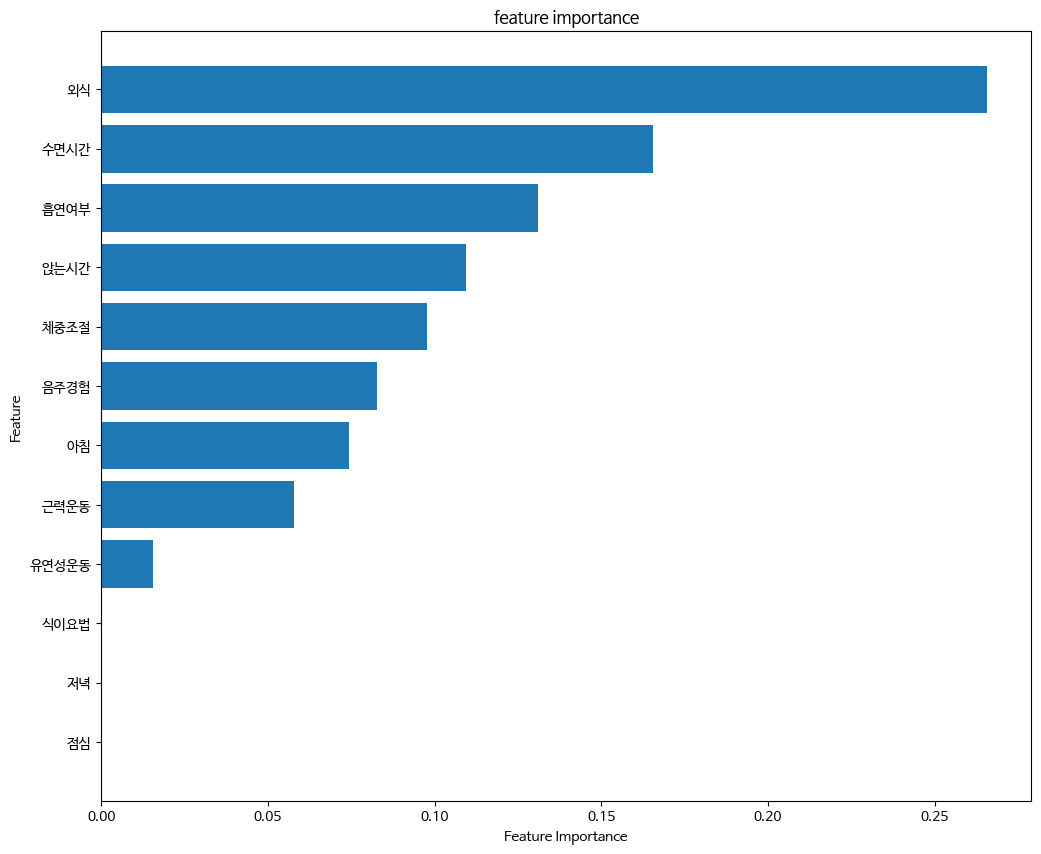

현재 model : CatBoostClassifier


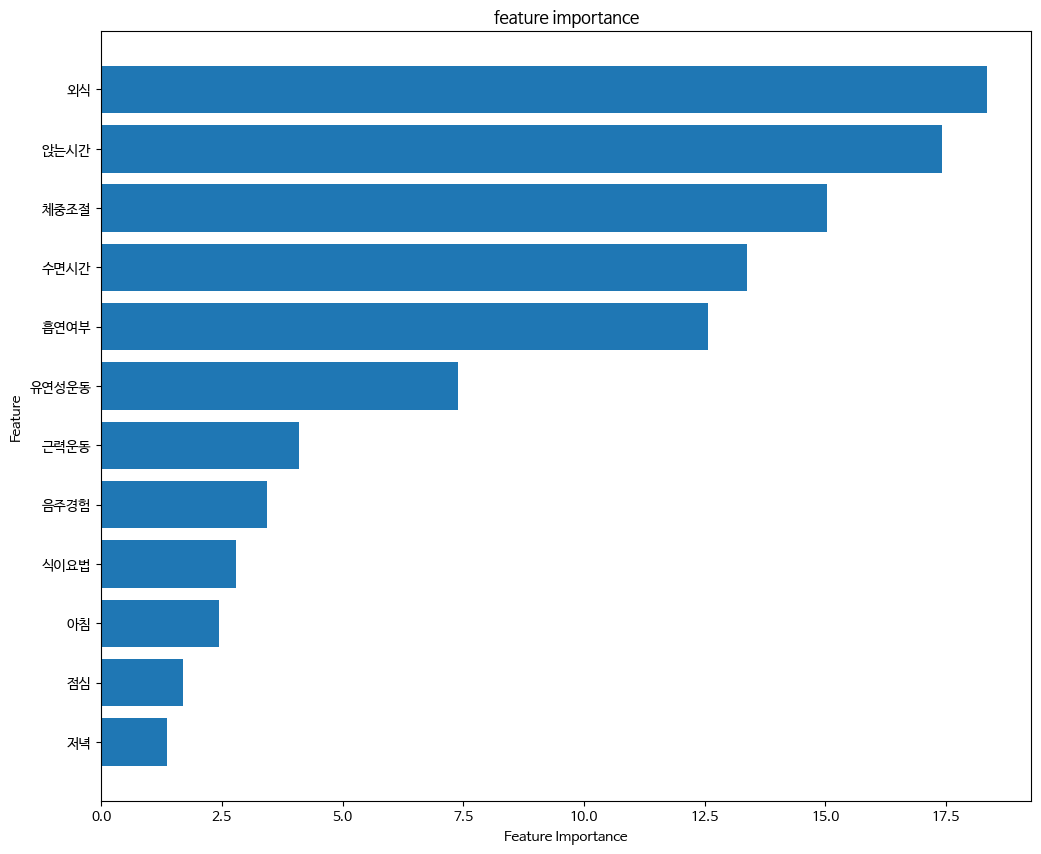

In [ ]:
for feature_model in [rf_best_model, lgb_best_model, xgb_best_model, cat_best_model]:
    if 'Cat' in feature_model.__class__.__name__:
        feature_importances = feature_model.get_feature_importance()
    else :
        feature_importances = feature_model.feature_importances_

    print("현재 model :",feature_model.__class__.__name__)
    plt.figure(figsize=(12, 10))
    plt.barh(range(len(feature_importances)), feature_importances[np.argsort(feature_importances)], align='center')
    plt.yticks(range(len(feature_importances)), np.array(x_train.columns)[np.argsort(feature_importances)])
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title('feature importance')
    plt.show()